<a href="https://colab.research.google.com/github/Sukantasai/Spam-Classification-Project-/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle


In [ ]:
# Load dataset
df = pd.read_csv("combined_20k_dataset.csv",encoding='ISO-8859-1')  # Ensure correct path
# Clean target column and remove null values
df['target'] = df['target'].str.strip().str.lower()
df = df.dropna(subset=['target'])

In [ ]:
df.head()

,target,text
0,spam,Congratulations! You've been selected for a lu...
1,spam,URGENT: Your account has been compromised. Cli...
2,spam,You've won a free iPhone! Claim your prize by ...
3,spam,Act now and receive a 50% discount on all purc...
4,spam,Important notice: Your subscription will expir...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22105 entries, 0 to 22106
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  22105 non-null  object
 1   text    22105 non-null  object
dtypes: object(2)
memory usage: 518.1+ KB


In [ ]:
df['target'].value_counts()

,count
target,
ham,18205
spam,3900


In [ ]:
# Preprocessing function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

In [ ]:
# Encode labels (spam -> 1, ham -> 0)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['target'])

In [ ]:
# Tokenization
max_words = 5000  # Max vocabulary size
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

In [ ]:
# Padding sequences
max_length = 100  # Define max length for padding
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [ ]:

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['label'], test_size=0.2, random_state=42)


In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
max_len = padded_sequences.shape[1]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     5,515,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,572,633 (21.26 MB)

 Trainable params: 5,572,633 (21.26 MB)

 Non-trainable params: 0 (0.00 B)

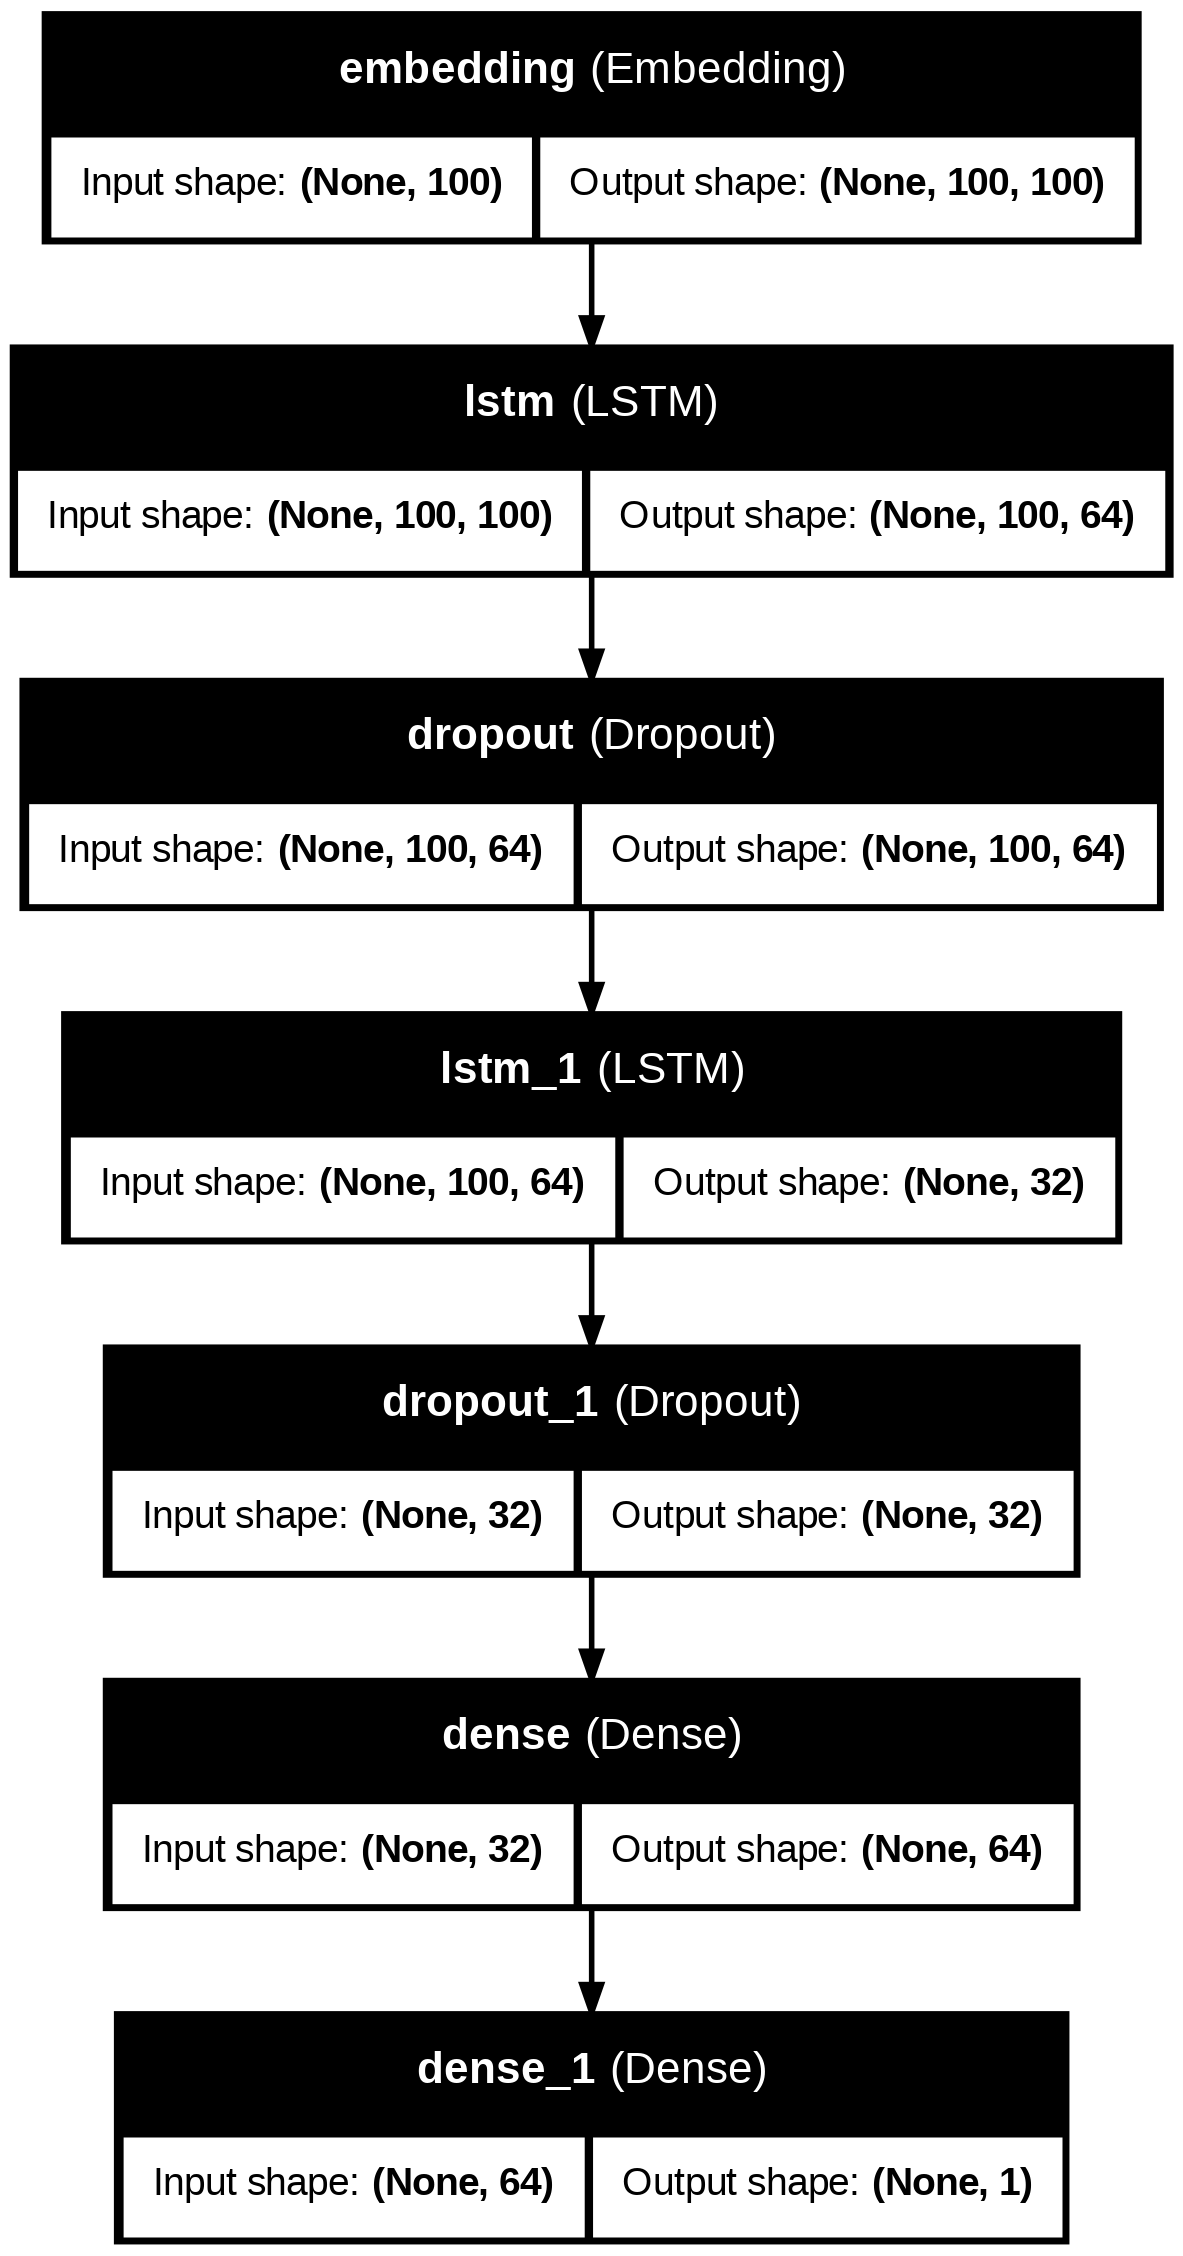

In [ ]:
!pip install pydot
!pip install graphviz
from tensorflow.keras.utils import plot_model

# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))  # removed input_length
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build model manually with input shape (batch_size is None, max_len is your padded input length)
model.build(input_shape=(None, max_len))

# Show model summary
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train model

from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model with Early Stopping
history = model.fit(
    X_train, y_train,
    epochs=9,  # Increased epochs to allow EarlyStopping to take effect
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/9
553/553 ━━━━━━━━━━━━━━━━━━━━ 115s 198ms/step - accuracy: 0.8406 - loss: 0.4484 - val_accuracy: 0.9104 - val_loss: 0.3033
Epoch 2/9
553/553 ━━━━━━━━━━━━━━━━━━━━ 133s 181ms/step - accuracy: 0.9201 - loss: 0.2696 - val_accuracy: 0.9195 - val_loss: 0.2581
Epoch 3/9
553/553 ━━━━━━━━━━━━━━━━━━━━ 140s 178ms/step - accuracy: 0.9487 - loss: 0.1805 - val_accuracy: 0.9636 - val_loss: 0.1167
Epoch 4/9
553/553 ━━━━━━━━━━━━━━━━━━━━ 98s 176ms/step - accuracy: 0.9770 - loss: 0.0864 - val_accuracy: 0.9805 - val_loss: 0.0737
Epoch 5/9
553/553 ━━━━━━━━━━━━━━━━━━━━ 145s 182ms/step - accuracy: 0.9878 - loss: 0.0513 - val_accuracy: 0.9808 - val_loss: 0.0671
Epoch 6/9
553/553 ━━━━━━━━━━━━━━━━━━━━ 144s 186ms/step - accuracy: 0.9893 - loss: 0.0428 - val_accuracy: 0.9815 - val_loss: 0.0666
Epoch 7/9
553/553 ━━━━━━━━━━━━━━━━━━━━ 140s 183ms/step - accuracy: 0.9905 - loss: 0.0325 - val_accuracy: 0.9842 - val_loss: 0.0721
Epoch 8/9
553/553 ━━━━━━━━━━━━━━━━━━━━ 99s 179ms/step - accuracy: 0.9943 - loss: 0.0

In [ ]:
# Model Evaluation
y_pred = (model.predict(X_test) > 0.5).astype("int32")


139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step


In [ ]:
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy*100:.4f}")


Test Accuracy: 98.4166


In [ ]:
# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3631
           1       0.95      0.96      0.96       790

    accuracy                           0.98      4421
   macro avg       0.97      0.98      0.97      4421
weighted avg       0.98      0.98      0.98      4421



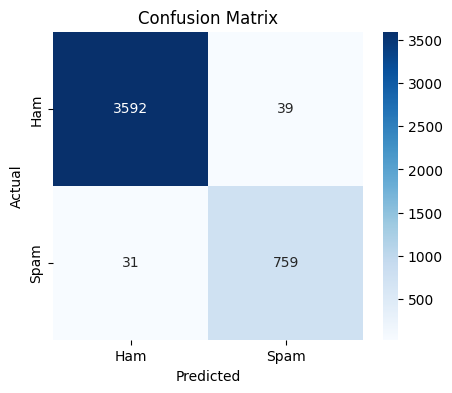

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


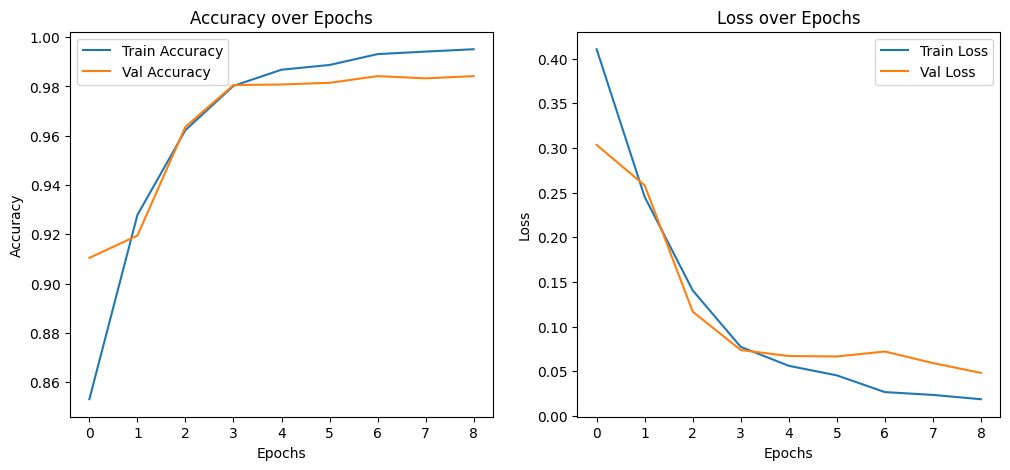

In [ ]:
# Plot Training & Validation Accuracy/Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()


In [ ]:
# Save the model using pickle
model_filename = "spam_detection_model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)


In [ ]:

# Save the tokenizer as well
tokenizer_filename = "tokenizer.pkl"
with open(tokenizer_filename, 'wb') as file:
    pickle.dump(tokenizer, file)

print("Model and tokenizer saved successfully.")

Model and tokenizer saved successfully.


In [ ]:
# Load the trained model and tokenizer
model_filename = "spam_detection_model.pkl"
tokenizer_filename = "tokenizer.pkl"

with open(model_filename, 'rb') as file:
    model = pickle.load(file)

with open(tokenizer_filename, 'rb') as file:
    tokenizer = pickle.load(file)


In [ ]:

# Preprocessing function for new messages
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text


In [ ]:
model.save("spam_lstm_model.h5")


In [ ]:
import os
print(os.listdir())


['.config', 'model_plot.png', 'combined_20k_dataset.csv', 'spam_lstm_model.h5', 'spam_detection_model.pkl', 'tokenizer.pkl', 'sample_data']


In [ ]:

# Function to predict if a message is spam or ham
def predict_message(message):
    cleaned_message = clean_text(message)  # Clean the text
    sequence = tokenizer.texts_to_sequences([cleaned_message])  # Tokenize
    padded_sequence = pad_sequences(sequence, maxlen=100, padding='post')  # Pad sequence

    prediction = model.predict(padded_sequence)[0][0]  # Get probability score
    result = "Spam" if prediction > 0.5 else "Ham"  # Thresholding at 0.5

    return result
# Example Predictions
print("Sample Email Prediction:",predict_message("Wealth secret of India's richest! Send '168' to https://tinyurl.com/kkrhnnhv for investment logic of top earners! Limited offer!"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Sample Email Prediction: Spam
